# Update Trajectories and Bayesian Flow Distribution

This notebook reproduces Figure 4 from [Bayesian Flow Networks (Graves et al. 2023)](https://arxiv.org/pdf/2308.07037.pdf). It first explores the update trajectories of the parameters $\mu$ in isolation, and then it overlays the trajectories over a log-scale heatmap of the Bayesian flow distribution.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.stats import norm
import torch

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
from bfn.bayesian_flow_networks import compute_beta, bayesian_flow_distribution
from bfn.generation import simulate_trajectory
from bfn.plotting_utils import get_next_color

## Define constants
We will be considering modeling a 1D datapoint $x=0.8$, with initial parameters $\theta_0 = \{\mu_0=0, \rho_0=1\}$.

In [3]:
theta_0 = torch.tensor(0), torch.tensor(1)
x = 0.8

intervals = 100
t_lo, t_hi = 0, 1
t_values = torch.linspace(t_lo, t_hi, intervals)


## Plotting code

In [4]:
def visualize_single_trajectory(t_values, mus, ys, rhos):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  color_gen = get_next_color(plt.cm.tab10)

  # plot mu
  color = next(color_gen)
  axs[0].plot(t_values, mus[:-1], label='$\\mu$', color=color)
  axs[0].scatter(t_values, ys, label='$y$', color=color, alpha=0.2)
  axs[0].set_title('Stochastic trajectory of $\\mu$ by applying the Bayesian update function')
  axs[0].legend()

  # plot rho
  color = next(color_gen)
  axs[1].plot(t_values, rhos[:-1], label='$\\rho$', color=color)
  axs[1].set_title('Deterministic trajectory of $\\rho$ by applying the Bayesian update function')
  log_rho_ax = axs[1].twinx()
  log_rho_ax.plot(t_values, rhos[:-1], color=color, linestyle='dashed', alpha=0.5, label='log scale')
  log_rho_ax.set_yscale('log')
  log_rho_ax.legend()

  for ax in axs:
    ax.set_xlabel('Time $t$')

  plt.legend()
  return axs

In [5]:
def visualize_multiple_trajectories(t_values, all_mus, all_ys, colormap):
  color_gen = get_next_color(colormap, n_colors=len(all_mus))

  for i, (mus, ys) in enumerate(zip(all_mus, all_ys)):
    color = next(color_gen)
    # plot mu
    plt.plot(t_values, mus[:-1], color=color, linewidth=0.5)
    # plot y
    plt.scatter(t_values, ys, color=color, alpha=0.2, s=5)

  plt.title('Stochastic trajectory of $\\mu$s by applying the Bayesian update function')
  plt.xlabel('Time $t$')


## Plot single trajectory of $\theta$

> From a given final desired standard distribution $\sigma_1$ of the input distribution $p_I(\cdot | \bm{\theta})$ over $\mathbf{x}$, we can automatically calculate the accuracy schedule $\beta(t)$ as
> 
> \begin{align}
> \beta(t) &= \sigma_1^{-2t} -1. \tag{72} \\
> \end{align}
> 
> Then given prior parameters $\bm{\theta}_0$, accuracy schedule $\beta(t)$, consider a sequence of $n$ sender samples $\mathbf{y}_1, ..., \mathbf{y}_n$ sampled at times $t_1, ..., t_n$ where $t_i = i/n$. The sender distribution at step $i$ is $p_S(\cdot | \mathbf{x}; \alpha_i)$, where
> 
> \begin{align}
> \alpha_i &= \beta(t_i) - \beta(t_{i-1}). \tag{11} \\
> \end{align}
> 
> Starting with initial parameters $\bm{\theta}_0$ and alternating between sampling $\mathbf{y}$ from the sender distribution and updating the previous parameters $\theta_{i-1}$ to new parameters $\theta_i$ with the Bayesian update function $h(\bm{\theta}_{i-1}, \mathbf{y}, \alpha_i)$ generates a trajectory of sequence of updated parameters $\bm{\theta}_1, ..., \bm{\theta}_n$." Note that the starting time index for $\bm{\theta}$ and $\beta$ is $0$, while the starting index for $\alpha$ and $\mathbf{y}$ is 1.

(_The above description is adapted from the text of section 3.7._)

$\sigma_1$ is defined as the desired standard deviation of the input distribution at $t=1$. With $\theta_0 = \{\mu_0=0, \rho_0=1\}$, $\sigma_1 = 0.02$, and $x = 0.8$, we plot the trajectory of $\theta = \{\mu, \rho\}$ below, as well as the samples $y$, shown as dots. Note that the updates of $\mu$ are stochastic and the updates of $\rho$ are deterministic. The trajectory of $\mu$ gradually converges upon the data $x = 0.8$, while the trajectory of $\rho$ follows an exponential curve.

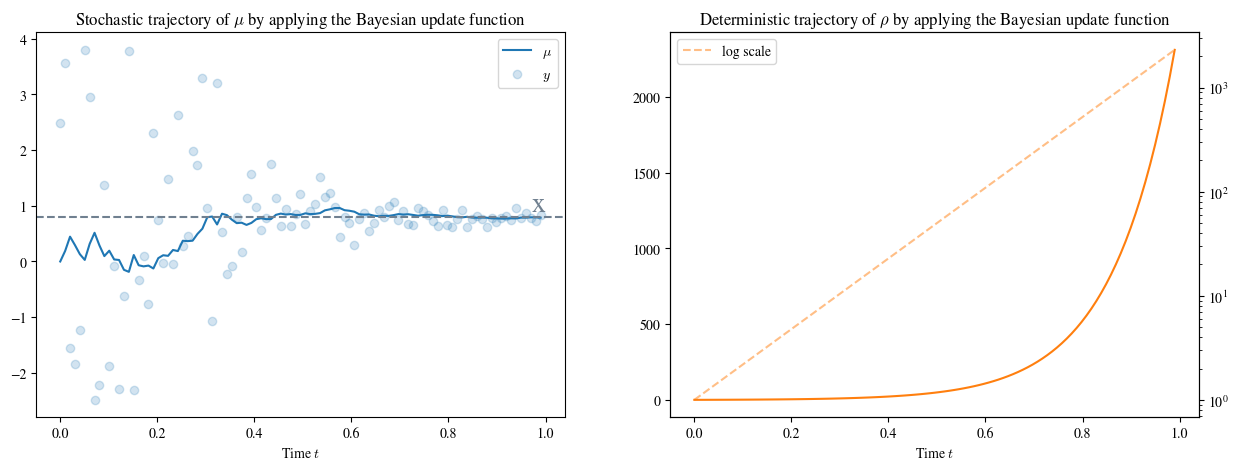

In [6]:
sigma_1 = torch.tensor(0.02)

betas = compute_beta(sigma_1, t_values)

# assert that equation 70 holds: given sigma_1, it is clear what beta should be
assert sigma_1**2 == 1/(1+betas[-1])

alphas = betas[1:]-betas[:-1]
mus, rhos, ys = simulate_trajectory(theta_0, alphas, x)

axs = visualize_single_trajectory(t_values[:-1], mus, ys, rhos)
axs[0].axhline(y=x, color='slategray', linestyle='--')
axs[0].text(t_values[-1], x, 'x', verticalalignment='bottom', horizontalalignment='right', color='slategray', fontsize=20)
plt.show()

## Plot multiple trajectories of $\mu$
To give us a sense of the distribution over trajectories over $\mu$, the figure below plots multiple trajectories. Different colors correspond to different trajectories. As in the previous plot, the colored dots represents samples $y$ corresponding to their respectively colored trajectories $\mu$. Note that all trajectories begin at $\mu_0=0$ and converge towards $x=0.8$. Note also that the spread of the samples $y$ from the sender distribution are much wider than the spread of the values of $\mu$.

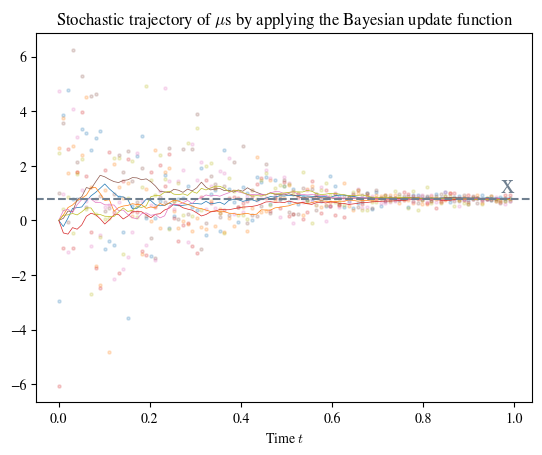

In [7]:
num_trajectories = 6

sigma_1 = torch.tensor(0.02)
betas = compute_beta(sigma_1, t_values)
alphas = betas[1:]-betas[:-1]
mus, rhos, ys = zip(*[simulate_trajectory(theta_0, alphas, x) for _ in range(num_trajectories)])
visualize_multiple_trajectories(t_values[:-1], mus, ys, colormap=plt.cm.tab10)
plt.axhline(y=x, color='slategray', linestyle='--')
plt.text(t_values[-1], x, 'x', verticalalignment='bottom', horizontalalignment='right', color='slategray', fontsize=20)
plt.show()

## How  does $\sigma_1$ affect the trajectories?
The plot below visualizes how setting the final desired standard distribution $\sigma_1$ of the input distribution $p_I(\cdot | \theta)$ affects the samples $y$ from the sender distribution and the trajectories over $\theta$. As before, the colored dots represents samples $y$ and the lines correspond to the trajectories of $\mu$. Blue corresponds to $\sigma_1 = 0.4$ and red corresponds to $\sigma_1 = 0.02$. For each value of $\sigma_1$ we show multiple trajectories, each corresponding to a different shade of its respective color.

As we can see, increasing $\sigma_1$ affects the spread of the sender samples $y$ but does not increase the spread of the parameter trajectories $\mu$. 

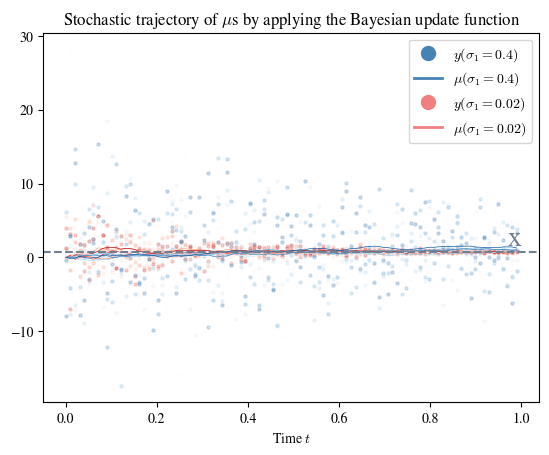

In [8]:
num_trajectories = 6

for sigma_1 in torch.tensor([0.02, 0.4]):
  if sigma_1 == 0.02:
    colormap = plt.cm.Reds
  elif sigma_1 == 0.4:
    colormap = plt.cm.Blues

  betas = compute_beta(sigma_1, t_values)
  alphas = betas[1:]-betas[:-1]
  mus, rhos, ys = zip(*[simulate_trajectory(theta_0, alphas, x) for _ in range(num_trajectories)])

  visualize_multiple_trajectories(t_values[:-1], mus, ys, colormap=colormap)

plt.axhline(y=x, color='slategray', linestyle='--')
plt.text(t_values[-1], x, 'x', verticalalignment='bottom', horizontalalignment='right', color='slategray', fontsize=20)
plt.legend(handles=[
    plt.Line2D([0], [0], linestyle='None', marker='o', color='steelblue', markerfacecolor='steelblue', markersize=10, label='$y (\sigma_1=0.4)$'),
    plt.Line2D([0], [0], color='steelblue', linewidth=2, label='$\mu (\sigma_1=0.4)$'),
    plt.Line2D([0], [0], linestyle='None', marker='o', color='lightcoral', markerfacecolor='lightcoral', markersize=10, label='$y (\sigma_1=0.02)$'),
    plt.Line2D([0], [0], color='lightcoral', linewidth=2, label='$\mu (\sigma_1=0.02)$'),
])
plt.show()

## Bayesian Flow Distribution

The Bayesian flow distribution $p_F(\bm{\theta} | \mathbf{x}; t)$ can be calculated as a normal distribution with mean $\gamma(t)\mathbf{x}$ and variance $\gamma(t)(1-\gamma(t))\mathbf{I}$, where
\begin{align}
\gamma(t) &:= \frac{\beta(t)}{1+\beta(t)} \tag{78} \\
&= 1- \sigma_1^{2t},
\end{align}
where $\beta(t)$ is the accuracy schedule and $\sigma_1$ is the desired standard deviation of the input distribution at $t=1$. How this parameterization of the Bayesian flow distribution is derived can be found in _Section 4.6_.

> "For $x=0.8$, $\sigma_1=0.02$, the plot shows stochastic parameter trajectories for the input distribution mean $\mu$ (white lines) superimposed on a log-scale heatmap of the Bayesian flow distribution $p(\theta | x;t)$. Note how the trajectories all begin at $\mu_0=0$ then fan out before converging on $x$."

(_The above description is adapted from the caption of Figure 4._)

In [9]:
def visualize_bayesian_flow_distribution(x, mus, sigmas, t_range, x_range):
  t_lo, t_hi = t_range
  x_lo, x_hi = x_range

  x_values = np.linspace(x_lo, x_hi, 800)
  sigmas += 1e-8 # to avoid divide by 0

  Z = norm.pdf(x_values[:, None], mus[None, :], sigmas[None, :])

  plt.figure(figsize=(13,5))

  # NOTE: I was able to reproduce the colors of the heatmap by using 
  # `plt.imshow(Z+1, ...)` instead of `plt.imshow(Z)`. If someone finds a bug 
  # in the code that, if fixed, would reproduce the paper figure's heatmap 
  # colors with plt.imshow(Z, ...), please let me know!
  plt.imshow(Z+1,
            extent=[t_lo, t_hi, x_lo, x_hi],
            origin='lower',
            aspect='auto',
            cmap='jet',
            norm=LogNorm(),
            )

  plt.yticks(ticks=[-2, 0, 2], labels=[-2, f'$\mu_0=0$', 2])

  ax2 = plt.gca().twinx()
  ax2.set_ylim(plt.gca().get_ylim())
  ax2.set_yticks([0.8])
  ax2.set_yticklabels(['$x=0.8$'])

  plt.xlabel('Time (t)')
  plt.xticks([0,1])

  plt.title('Bayesian flow for continuous data')

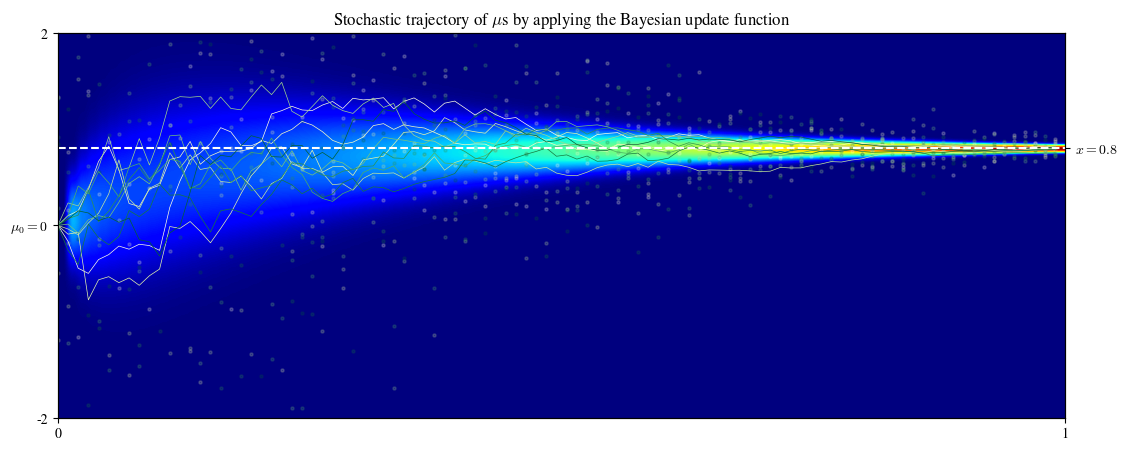

In [10]:
sigma_1 = torch.tensor(0.02)
x_lo, x_hi = -2, 2

# plot heatmap
mu, var = bayesian_flow_distribution(x, t_values, sigma_1)

visualize_bayesian_flow_distribution(x=x, mus=mu, sigmas=var**0.5,
                   t_range=(t_lo, t_hi), x_range=(x_lo, x_hi))

# plot trajectories
num_trajectories = 10
betas = compute_beta(sigma_1, t_values)
alphas = betas[1:]-betas[:-1]
mus, rhos, ys = zip(*[simulate_trajectory(theta_0, alphas, x) for _ in range(num_trajectories)])

visualize_multiple_trajectories(t_values[:-1], mus, ys,
                                colormap=plt.cm.YlGn,
                                )
plt.axhline(y=x, color='white', linestyle='--')

# NOTE that the y values actually go out of the (-2, 2) range, but the paper
# capped the y limits as (-2, 2) so we will also go with that.
plt.ylim(x_lo, x_hi)

plt.show()